# 7CUSMSDA Practical Week 9 :  Street Network Analysis
<a href="#This Week's Overview">This Week's Overview</a>

<a href="#Learn Outcomes">Learn Outcomes</a> 

<a href='#Get prepared'>Get prepared</a>
- <a href='#Import libraries'>Import libraries</a>
- <a href='#Data for Section I'>Data for Section I</a>

<a href='#Networkx Routing'>Networkx Routing</a>

<a href='#OSMnx Routing'>OSMnx Routing</a>
- <a href='#Walk Routing from Bush House'>Walk Routing from Bush House</a>
  - <a href='#Street Network Centrality'>Street Network Centrality<a/>
  - <a href='#Street Network Simplification'>Street Network Simplification<a/>
- <a href='#Task 1'>Task 1<a/> 
- <a href='#Drive routing in Westminster'>Drive routing in Westminster<a/>
  - <a href='#Descriptives for street network'>Descriptives for street network<a/>
  - <a href='#Get and Save Shapefiles'>Get and Save Shapefiles<a/>
  - <a href='#Routing'>Routing<a/>
    - <a href='#1. Network path from the centermost node to another node'>1. Network path from the centermost node to another node<a/>
    - <a href='#2. Network path from one lat-long to another'>2. Network path from one lat-long to another<a/>
    - <a href='#3. Routing with one-way streets'>3. Routing with one-way streets<a/>
    - <a href='#4. Plot a route as an interactive web map'>4. Plot a route as an interactive web map<a/>
    - <a href='#5. Draw isochrone map'>5. Draw isochrone map<a/>
    - <a href='#6. Orientation--street network bearings'>6. Orientation--street network bearings<a/>
  - <a href='#(Optional) Routes over interactive westminster street network'>(Optional) Routes over interactive westminster street network<a/>
- <a href='#Task 2'>Task 2<a/> 

# <a id="This Week's Overview">This Week's Overview</a>

We are familiar with getting help from navigation devices and services for routing along the road networks. For example, you want to know the shortest route from your home to our lab, just simply enter the addresses/postcodes for starting point and ending point into the application (or Google map, as you always use), it will calculate the shortest path for you in seconds. However, we want to how the shortest path has been calculated? What is the algorithm behind? Is there a better way for us to customize the searching process by ourselves? 

This week we will have two sections to work out the solution to calculate the shortest path on a road network using `NetworkX` and `OSMnx`. As you've been taught in Data Mining and Network Analysis modules, [NetworkX](https://networkx.github.io/#) is a Python language software package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It is a library with many algorithms to solve the problem, including Dijkstra (http://networkx.github.io/). It relies on `numpy` and `scipy` to perform some graph calculation and help with performance, we will also use the `smopy` for visualization when appropriate. If you are interested to explore more, networkX [official website](https://networkx.readthedocs.io/en/stable/tutorial/index.html) could be an ideal reservoir. In the first section, we will call `NetworkX` to realize shortest routing from Bush House to Heathrow Airport based on [Geographical distance](https://en.wikipedia.org/wiki/Geographical_distance) calculation, with [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) as the working basis. 

In the second section, a new library `OSMnx` will be introduced to query the shortest path routing s step further, both in area around Bush House and whole Westminster; the open street map and folium visualization will be called frequently, so get your temper prepared as the interactive map calling always takes time......Besides of our usual way to get street network data from packed shapefiles prepared by me, we will use `OSMnx` to get the street network data from open street map directly this time. I can't tell you which way is better, you may find the most efficient and accurate path by yourself.

# <a id="Learn Outcomes">Learn Outcomes</a> 

By the end of this practical, you should be able to
- Better apply your skills on Network Analysis
- Conduct shortest path routing using both libraries provided 
- Visualize your output on open street map

# <a id='Get prepared'>Get prepared</a>
## <a id='Import libraries'>Import libraries</a>

In [1]:
import networkx as nx
import numpy as np
import pysal as ps
%pylab inline
import json
from geojson import loads, Feature, FeatureCollection
import io
import sys
import zipfile
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import smopy
from descartes import PolygonPatch

import shapefile
from shapely.geometry import asShape, asLineString, asMultiPoint, Point, LineString, Polygon, MultiPolygon
from descartes import PolygonPatch

from IPython.display import IFrame
from IPython.core.pylabtools import figsize
figsize(8, 6)

import osmnx as ox
ox.config(log_file=True, log_console=True, use_cache=True)

import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


## <a id='Data for Section I'>Data for Section I</a>

For section I, we want to find the shortest path from Bush House to Heathrow Airport. To compute the directions from Point A on a map to point B, some lights on [routing](https://stackoverflow.com/questions/430142/what-algorithms-compute-directions-from-point-a-to-point-b-on-a-map) could be shed on us. I had retrieved London roads network from OpenStreetMap data in London Datastore, and save the London road network shapefile at [here](https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/road_network.zip). To prepare the data, you may:

- run the section of code below, or;
- click the above link to download the zip file, then unzip it.

Here `NetworkX`'s nice function `read_shp` can read the shapefile dataset containing primary roads network information in London, and return a graph with each node is a geograhical location, and the edges contain corresponding information on roads linking the two nodes.

In [ ]:
url = ('https://github.com/cusp-london/'
       'Spatial-Data-Analysis/blob/master/road_network.zip?raw=true')
r = io.BytesIO(requests.get(url).content)
zipfile.ZipFile(r).extractall('road_network')


In [2]:
g = nx.read_shp('data/road_network/road_network/gis_osm_roads_free_1.shp')

## <a id='Networkx Routing'>Networkx Routing</a> 

We will compute the shortest path with `NetworkX`'s `shortest_path` function, which used Dijkstra's algorithm. To calculate the geographical distance between two locations(points), we choose [orthodromic distance](https://en.wikipedia.org/wiki/Great-circle_distance) which assumes earth is a perfect sphere (but if your data has some successive points on a small road, then we could use a simpler formula to measure the distance). Dijkstra's shortest path algorithm, conceived by Dutch computer scientist Edsger Dijkstra in 1956 and published in 1959, has a wide variety of applications in network routing. For a given source vertex (node) in a graph, this algorithm finds the path with lowest cost (i.e. the shortest path) between that vertex and every other vertex. So if the vertices represent cities, then the **edge path costs** stands for driving distances between assigned pairs of cities connected by direct road(s). There are many resources on interpreting Dijkstra algorithm, for example: https://www.youtube.com/watch?v=gdmfOwyQlcI. 

As the starting point, the input road network Shapefile is a completely connected network dataset. Sometimes, you may find that your own data/input is not connected, so we need to call function `connected_components` to find nodes that are connected, whilst sets our network to `undirected` for further use. 

In [14]:
largest_cc = max(nx.connected_components(g.to_undirected()), key=len) # largestest connected nodes
len(largest_cc)

71337

In [20]:
sg = g.subgraph(largest_cc)
type(sg)

networkx.classes.digraph.DiGraph

Next we set the array position of the start and end node to calculate our route. The `shortest_path` algorithm requires you to define the start and end nodes, which are both coordinates of the defined points. Here we choose **Bush House** as the start node and **Heathrow Airport** as the end node.

In [25]:
start_node = (51.5125, -0.1170) # Bush House, King's College London
end_node = (51.4700, -0.4543) # Heathrow Airport

Then as we need a path, hence we will build up the `get_path` and `get_full_path` functions: 

`get_path` function takes two input nodes, and returns a NumPy array of edge coordinates along the path. 

In [15]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

`get_full_path` function internally uses the `get_path` function to put the complete list of all paths and coordinates along all paths.

In [16]:
def get_full_path(path):
    """
    Create numpy array line result
    :param path:results of nx.shortest_path function
    :return: the coordinate pairs along a path."""
    p_list = []
    c = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if c is None:
            c = p
        if (np.sum((p[0] - c) ** 2) >
                np.sum((p[-1] - c) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        c = p[-1]
    return np.vstack(p_list)

From the loop above, all the edges and corresponding coordinates are appended to a list that needs to be combined through NumPy `vstack` function. The procedure is, we go through each path, getting the edges and coordinates, then build the concatenated list as final NumPy array output.

`Shapely` was built with `NumPy` compatibility and, therefore, has an `asLineString` function directly inputting a `NumPy` array of coordinates. 

After we get the road path, we can calculate its length upon defining the geographical coordinates as below function `geocalc` and `get_path_length`.

In [17]:
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [18]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))

Edge will contain information on points along the road, this function will return the array of coordinates

In [21]:
# Compute the length of the road segments.
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

In [22]:
nodes = np.array(sg.nodes)

In [26]:
# Get the closest two nodes to two requested locations in the graph.
start_node_i = np.argmin(np.sum((nodes[:, ::-1] - start_node)**2, axis=1))
end_node_i = np.argmin(np.sum((nodes[:, ::-1] - end_node)**2, axis=1))

In [27]:
# Compute the shortest path.
path = nx.shortest_path(
    sg,
    source=tuple(nodes[start_node_i]),
    target=tuple(nodes[end_node_i]),
    weight='distance')   # the weight for each road has been specified as the distance from the target locations.
len(path)

261

Is `len` here get you the length of the path? What does number 225 indicate for? You may get your answer below.

In [28]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['name','fclass','distance'])
roads

,name,fclass,distance
0,Strand,primary,0.081846
1,Strand,primary,0.017810
2,Strand,primary,0.065263
3,Strand,primary,0.044134
4,Strand,primary,0.006245
...,...,...,...
255,Inner Ring East,tertiary,0.012819
256,Inner Ring East,tertiary,0.090726
257,Cosmopolitan Way,unclassified,0.202620
258,Cosmopolitan Way,unclassified,0.014277


Then we get the real distance value from our starting node to ending node.

In [ ]:
roads['distance'].sum() # total lengh of the itinerary in kilometres

In [29]:
m = smopy.Map((51.5125, -0.1170, 51.4700, -0.4543), z=10, margin=.5) # retrive the graph from smopy

We will get the path visualized on openstreetmap, with connected nodes in the graphy, and concatenate the positions along every edge in the path in the right order (the last node in one edge needs to be close to the first node in next edge). 

In [30]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0]) # convert the path to pixel to show on the map

In [31]:
linepath[:, 1]

array([51.511853 , 51.5119122, 51.5119693, ..., 51.4702538, 51.4702221,
       51.4701815])

NameError: name 'x' is not defined

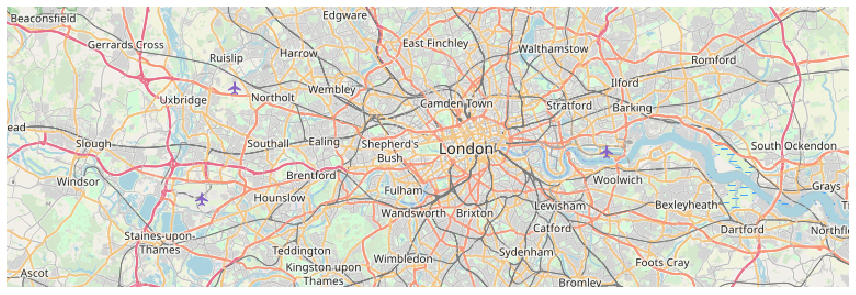

In [8]:
ax = m.show_mpl(figsize=(12, 12))
# Plot the itinerary.
ax.plot(x, y, 'k', lw=2) # define the linecolor as black and linewidth at 2
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=8)  # define the marker as blue circle at size 8
ax.plot(x[-1], y[-1], 'or', ms=8) # define the marker as red circle at size 8

# <a id='OSMnx Routing'>OSMnx Routing</a>

[OSMnx](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.core) is a Python library developed by Geoff Boeing, that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API. It enables you to download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or shapefiles for further use. Under OSMnx, you can download a street network by any of the following:
- a bounding box
- a lat-long point plus a distance
- an address plus a distance
- a place name or list of place names 
- a polygon of the desired street network's boundaries

You can also specify several network types:
- 'drive' - get drivable public streets (but not service roads)
- 'drive_service' - get drivable streets, including service roads
- 'walk' - get all streets and paths that pedestrians can use 
- 'bike' - get all streets and paths that cyclists can use
- 'all' - download all non-private OSM streets and paths 
- 'all_private' - download all OSM streets and paths, including private-access ones

In this practical, we will have the opportunity to "play" with most of them, e.g. get the map for westminster area, the bounding box area around Bush House within defined distances; the drive path and walking path around target areas, etc.

**Be patient**, as the loading of open street map really takes time!

(Acknowledgement: This section has been illuminated by gboeing's work using osmnx.)

## <a id='Walk Routing from Bush House'>Walk Routing from Bush House</a>
Let's get the walk routing around Bush House within 0.5 mile (just to save time).

In [ ]:
# get network by coordinates
# useful when OSM just doesn't have a polygon for the place you want
bush_house = (51.5125, -0.1170)
half_miles = 805 #meters
G1 = ox.graph_from_point(bush_house, distance=half_miles, network_type='walk')
fig, ax = ox.plot_graph(G1, fig_height=8, node_size=0)

You will get an output looking like a bounding box, and now let's further conduct the spatial centrality analysis of it.

In [ ]:
# project a street network
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1, bgcolor='k', node_size=5, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1)

### <a id='Street Network Centrality'>Street Network Centrality<a/>

In [ ]:
# node closeness centrality
node_centrality = nx.closeness_centrality(G1)
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G1.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G1, bgcolor='k', node_size=5, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1, edge_alpha=1)

In [ ]:
# edge closeness centrality: convert graph to a line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G1))

# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G1.edges()]

# color scale converted to list of colors for graph edges
norm = mpl.colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G1, bgcolor='k', axis_off=True, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

In [ ]:
# save a shapefile with centrality as node and edge attributes
nx.set_node_attributes(G1, node_centrality, 'node_centrality')
nx.set_edge_attributes(G1, edge_centrality, 'edge_centrality')
ox.save_graph_shapefile(G1)

### <a id='Street Network Simplification'>Street Network Simplification<a/>

In [ ]:
# create a network around bush house point and plot it
G2 = ox.graph_from_point(bush_house, distance=half_miles, simplify=False)
fig, ax = ox.plot_graph(G2, node_color='b', node_zorder=3)

In [ ]:
# show which nodes we'd remove if we simplify it
nc = ['b' if ox.is_endpoint(G2, node) else 'r' for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc, node_zorder=3)

In [ ]:
# simplify the network
G3 = G2.copy()
G3 = ox.simplify_graph(G2)

# plot the simplified network and show any loops in magenta
loops = [edge[0] for edge in nx.selfloop_edges(G3)]
nc = ['m' if node in loops else 'b' for node in G3.nodes()]
fig, ax = ox.plot_graph(G3, node_color=nc, node_zorder=3)

Can you manage to locate the differences between plots for G3 and G2? Are they reflection of the red nodes then?

In [ ]:
# show the strictly simplified network with edges colored by network length
ec = ox.get_edge_colors_by_attr(G3, attr='length')
fig, ax = ox.plot_graph(G3, node_color='w', node_edgecolor='k', node_size=10, 
                        node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:
# plot same network again (topologically isomorphic), this time ignoring the edges' spatial geometry
ec = ox.get_edge_colors_by_attr(G3, attr='length')
fig, ax = ox.plot_graph(G3, node_color='w', node_edgecolor='k', node_size=10, node_zorder=3, 
                           edge_color=ec, edge_linewidth=3, edge_alpha=1, use_geom=False)

In [ ]:
# highlight all parallel edges
ec = ['b' if key == 0 else 'r' for u, v, key in G3.edges(keys=True)]
fig, ax = ox.plot_graph(G3, node_color='w', node_edgecolor='k', 
                        node_size=10, node_zorder=3, edge_color=ec, edge_linewidth=2)

## <a id='Task 1'>Task 1<a/> 
Create a 'drivable' street network around Bush House then simplify it.
1. create a street network within 2000metres distance around Bush House, replace the type 'walk' with 'drive'
2. plot the network
3. simplify the street network and plot
4. highlight one way streets around the area

In [ ]:
G4 = ox.graph_from_point(bush_house, distance=2000, network_type='drive', simplify=False)

In [ ]:
nc = ['b' if ox.is_endpoint(G4, node) else 'r' for node in G4.nodes()]
fig, ax = ox.plot_graph(G4, node_color=nc, node_zorder=3)

In [ ]:
G5 = G4.copy()
G5 = ox.simplify_graph(G5)

loops = [edge[0] for edge in nx.selfloop_edges(G5)]
nc = ['m' if node in loops else 'b' for node in G5.nodes()]
fig, ax = ox.plot_graph(G5, node_color=nc, node_zorder=3)

In [ ]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G5.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G5, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

To save the time, we just use a small dataset for illustrating; if you have a very large network dataset for large cities, you can image the how long it will take to simplify the graph, as the spatial geometries embedded as edge attributes can take a long time to get projected. So one solution could be to get the network for target city first but say `simplify=False`, then project the graph, then simplify its topology. 

## <a id='Drive routing in Westminster'>Drive routing in Westminster<a/>

In [ ]:
# get the driving network for westminster
place_query={'city':'Westminster', 'country':'GB'}
G = ox.graph_from_place(place_query, network_type='drive')
fig, ax = ox.plot_graph(G)

In [ ]:
# project the network to an appropriate UTM (automatically determined)
G_projected = ox.project_graph(G)
# plot/save figures as SVGs to work with in Adobe Illustrator
fig, ax = ox.plot_graph(G_projected, save=True, file_format='svg')

### <a id='Descriptives for street network'>Descriptives for street network<a/>
In order to calculate both the basic and extended descriptive metric and topological stats for our graph on Westminster street network, we can call `osmnx.stats` function. One of the prerequisite for density-based metrics calculation is to pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation). Let's have a look below:

In [ ]:
# what sized area does our network cover in square meters?
nodes_proj = ox.graph_to_gdfs(G_projected, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

In [ ]:
# show some basic stats about the network
stats=ox.basic_stats(G_projected, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
stats

To better interpret the output for basic statistics, more information could be get from: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats, and you can try to call the individual variable of interest.

In [ ]:
stats['clean_intersection_count']

There are extended statistics for topological stuff in `osmnx` as well, let's get the labels for measures by printing out the keys.

In [ ]:
# see more stats (mostly topological stuff) with extended_stats
# use arguments to turn other toplogical analyses on/off
more_stats = ox.extended_stats(G_projected, ecc=True, bc=False, cc=True) 
for key in sorted(more_stats.keys()):
    print(key)

Similarly, values for corresponding keys could be derived individually, for example we want to know the centrality feature, so we write the code as below:

In [ ]:
# pull up some stat's value
more_stats['closeness_centrality']

The measure `closeness_centrality` here is used to inspect node closeness centrality of street network in Westminster. To better interpret it, we could further do:

In [ ]:
max_node, max_cc = max(more_stats['closeness_centrality'].items(), key=lambda x: x[1])
max_node, max_cc # returns the id for the node with max. closeness contrality, and the value for the centrality

In Westminster, the node with the highest closeness centrality has 0.4% possibility of all other nodes close to it. Let's highlight it in the plot:

In [ ]:
nc = ['r' if node==max_node else 'b' for node in G_projected.nodes()]
ns = [30 if node==max_node else 5 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2)

### <a id='Get and Save Shapefiles'>Get and Save Shapefiles<a/>
In this section, we will try to save 3 shapefiles into our local directory, which are the Westminster polygon shapefile, the edges shapefile for the network and the nodes shapefile for the network.

In [ ]:
# get place shape
city = ox.gdf_from_place(place_query)
city

In [ ]:
# project the geometry to the appropriate UTM zone (calculated automatically) then plot it
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city)

In [ ]:
# save the polygon data for westminster
ox.save_gdf_shapefile(city)

Find the newly generated shapefile "gb-london-westminster" for London westminster from you "data" folder, and try to open it in QGIS to have a look.

In [ ]:
area = ox.project_gdf(city).unary_union.area
# get the street network, with retain_all=True to retain all the disconnected islands' networks
G = ox.graph_from_place(place_query, network_type='drive', retain_all=True)
G_projected = ox.project_graph(G)
# plot the network, but do not show it or close it yet
fig, ax = ox.plot_graph(G_projected, fig_height=10, show=False, close=False, edge_color='#777777')
plt.close()

In [ ]:
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)

In [ ]:
# optionally set up the axes extents all nicely
# get the network plot against polygon
margin = 0.1
west, south, east, north = city.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
fig

From both the basic and extended stats outputs in previous section, you may already find they are dicts, and the streets/intersection counts and proportions are nested dicts inside the stats. So if we want further compare or analyze the multiple networks against each other, we need to save the street networks as shapefiles; to realize this, we firstly want to convert these stats to a pandas dataframe , which requires unpacking these nested dicts:

In [ ]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=False, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats) # write into pandas series

In [ ]:
# unpack dicts into individiual keys:values
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats)).T

In [ ]:
# proportion of intersections that are cul-de-sacs or dead end, T-intersections, and X-intersections
print(stats['int_1_prop'])
print(stats['int_3_prop'])
print(stats['int_4_prop'])

In [ ]:
# how many streets emanate from each intersection?
G.graph['streets_per_node']

In [ ]:
# save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)
ox.save_graph_shapefile(G_projected, filename='westminsternetwork_shapefile')
ox.save_graphml(G_projected, filename='westminsternetwork.graphml') 

Again, check your "data" folder and open the newly saved shapefiles (edges and nodes) in QGIS to have a look.

We can also have a look of what's inside by the following codes to list some examples of nodes and edges.

In [ ]:
# nodes
list(G.nodes(data=True))[0:2]

In [ ]:
# edges
list(G.edges(keys=True, data=True))[0:2]

In [ ]:
# highlight all the deadends
nc = ['r' if G.graph['streets_per_node'][node]==1 else 'none' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=2, fig_height=8)

### <a id='Routing'>Routing<a/>
To try the routing functions in `osmnx`, we can realize various purposes within defined region like:
- calculate the network path from the centermost node to some other node;
- plot network path from one lat-long to another
- demonstrate routing with one-way streets
- draw isochrone map 


#### <a id='1. Network path from the centermost node to another node'>1. Network path from the centermost node to another node<a/>
The procedure could be: let the origin node be the node nearest the location, and let the destination node just be the last node in the network; find the shortest path between origin and destination, using weight='length' to find the shortest spatial path (otherwise it treats each edge as weight=1).

In [ ]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (51.5125, -0.1170)
G_c = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')

origin_node = ox.get_nearest_node(G_c, location_point)
destination_node = list(G_c.nodes())[-1]

In [ ]:
# find the route between these nodes then plot it
route_c = nx.shortest_path(G_c, origin_node, destination_node, weight='length')
route_c

In [ ]:
# inspect the first node in the route
G_c.node[route_c[0]]

In [ ]:
# what is the total length of the route?
nx.shortest_path_length(G_c, origin_node, destination_node, weight='length')

In [ ]:
# plot it
fig, ax = ox.plot_graph_route(G_c, route_c)

In [ ]:
# project the network to UTM (zone calculated automatically) then plot the network/route again
G_c_proj = ox.project_graph(G_c)
fig, ax = ox.plot_graph_route(G_c_proj, route_c)

#### <a id='2. Network path from one lat-long to another'>2. Network path from one lat-long to another<a/>

In [ ]:
# get the nearest network node to each point
# define origin/desination points
origin_point =(51.5125, -0.1170)# original point at Bush House, King's College London
destination_point = (51.500950, -0.141826)# destination point at Buckingham Palace

orig_node = ox.get_nearest_node(G, origin_point) 
dest_node = ox.get_nearest_node(G, destination_point) 
origin_node, destination_node

In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
str(route)

In [ ]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, 
                              destination_point=destination_point, node_size=5, fig_height=8)

In [ ]:
# how long is our route in meters?
nx.shortest_path_length(G, orig_node, dest_node, weight='length')

#### <a id='3. Routing with one-way streets'>3. Routing with one-way streets<a/>
We can get "G" through either `graph_from_address` or `graph_from_point`, you will find the outputs are similar.

In [ ]:
G = ox.graph_from_address('Bush House, Westminster, London', distance=3000, network_type='drive')
origin = (51.5125, -0.1170)
destination = (51.500950, -0.141826)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route, save=True, filename='route')

In [ ]:
location_point = (51.5125, -0.1170)
G = ox.graph_from_point(location_point, distance=3000, network_type='drive', clean_periphery=False)
origin = (51.5125, -0.1170)
destination = (51.500950, -0.141826)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

## <a id='Task 2'>Task 2<a/>
Can you get the walk path routing from Bush House to Covent Garden? Your code here:
**Hint**: there are various ways to get your "G" upon your preference.

Similarly, we could also simplify, plot the parallel and one-way routes in your defined network.

In [ ]:
# show the simplified network with edges colored by edge length
ec = ox.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='r', node_edgecolor='r', node_size=0.1, 
                           node_zorder=3, edge_color=ec, edge_linewidth=1)

In [ ]:
# highlight all parallel edges in purple
ec = ['orange' if key == 0 else 'purple' for u, v, key in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=0.1, 
                           node_zorder=3, edge_color=ec, edge_linewidth=1)

In [ ]:
# highlight all the one-way edges in the mission district network from earlier
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1, edge_alpha=0.3)

#### <a id='4. Plot a route as an interactive web map'>4. Plot a route as an interactive web map<a/>

In [ ]:
# use networkx to calculate the shortest path between two nodes
origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[4]
route = nx.shortest_path(G, origin_node, destination_node)

In [ ]:
# plot the route with folium
route_map = ox.plot_route_folium(G, route)

In [ ]:
# save as html file then display map as an iframe
# check it from your local directory as well
filepath = 'route.html'
route_map.save(filepath)
IFrame(filepath, width=600, height=400)

#### <a id='5. Draw isochrone map'>5. Draw isochrone map<a/>
How far can you travel on foot in Westminster for 5, 10, 15, 20 and 25 minutes respectively?

In [ ]:
# configure the place, network type, trip times, and travel speed
place_query={'city':'Westminster', 'country':'GB'}
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

Download and prep the street network

In [ ]:
# download the street network
G = ox.graph_from_place(place_query, network_type=network_type)
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [ ]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='rainbow', start=0.3, return_hex=True)

In [ ]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [ ]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

In [ ]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()


Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer
in the style of http://kuanbutts.com/2017/12/16/osmnx-isochrones/

In [ ]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

#### <a id='6. Orientation--street network bearings'>6. Orientation--street network bearings<a/>
Calculate street network bearings and visualize the spatial orientation of a street network.

In [ ]:
fig, ax = ox.plot_graph(ox.project_graph(G), node_size=0)

In [ ]:
# calculate edge bearings and visualize their frequency
G = ox.add_edge_bearings(G)
bearings = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])
ax = bearings.hist(bins=30, zorder=2, alpha=0.8)
xlim = ax.set_xlim(0, 360)
ax.set_title('Westminster street network edge bearings')
plt.show()

In [ ]:
# polar plot

n = 30
count, division = np.histogram(bearings, bins=[ang*360/n for ang in range(0,n+1)])
division = division[0:-1]
width =  2 * np.pi/n
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')
bars = ax.bar(division * np.pi/180 - width * 0.5 , count, width=width, bottom=0.0)
ax.set_title('Westminster street network edge bearings', y=1.1)
plt.show()

### <a id='(Optional) Routes over interactive westminster street network'>(Optional) Routes over interactive westminster street network<a/>
If you want to save your routes on top of the whole westminster street network for further use, especially in an interactive way, e.g. using `folium`, then you may want to try the following blocks of code. However, only do this part when you are free, as **!! it really takes time !!**

In [ ]:
G = ox.graph_from_place(place_query, network_type='drive')
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', tiles='stamenterrain', 
                                 edge_color=ec, edge_width=2)

In [ ]:
# save as html file then display map as an iframe
filepath = 'westminster.html'
graph_map.save(filepath)
IFrame(filepath, width=300, height=500)

Check the newly saved .html file in your directory, and you can zoom into the street network or click any edge to get more info.

In [ ]:
# plot the route with folium on top of the previously created graph_map
route_graph_map = ox.plot_route_folium(G, route, route_map=graph_map, popup_attribute='length')

In [ ]:
# save as html file then display map as an iframe
filepath = 'route_graph_westminster.html'
route_graph_map.save(filepath)
IFrame(filepath, width=600, height=400)

## Credits

#### Contributors:
The following individuals have contributed to these teaching materials: Yijing Li (yijing.li@kcl.ac.uk).

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).